In [1]:
# Various Imports

# Data science
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# TDA
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

# Load data

* relevant columns
    * `Imaging phenotype (cell type)`: ID of cell type. See dataframe `df_mmc` f or what each ID means
    * `X.X`: x-coordinate of cell
    * `Y.Y`: y-coordinate of cell
    * `sample_Xtile_Ytile`: type of sample (BALB for normal, MRL for diseased) and tile numbers

In [2]:
df_cells = pd.read_csv('mouse_spleen_data/MRLdatasetexpression.csv', index_col = None)
df_mmc = pd.read_excel("mouse_spleen_data/mmc2.xlsx")

/home/tnk/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
df_cells.head()

,Imaging phenotype cluster ID,CD45,Ly6C,TCR,Ly6G,CD19,CD169,CD106,CD3,CD1632,...,CD44,NKp46,X.X,Y.Y,Z.Z,MHCII,blank_Cy3_cyc15,blank_Cy5_cyc15,sample_Xtile_Ytile,niche cluster ID
0,9600,1577.675415,-154.301758,130.692184,-4.168493,560.691345,-504.231476,854.670105,-631.294189,385.935242,...,422.408691,515.130066,10,70,13,6712.812988,1665.967896,398.348389,BALBc-3_X05_Y03,32.0
1,9600,1017.838440,-93.069397,144.076584,40.010998,885.595520,-391.357544,62.764454,-474.201172,-469.634583,...,448.701660,171.880310,1000,294,12,2024.678711,1287.959229,421.991425,BALBc-3_X01_Y02,99.0
2,9600,5978.459961,-330.099365,139.631744,-82.840302,1747.897583,-395.508820,954.326782,-1026.204468,3744.718262,...,2229.804443,512.220764,1003,107,8,8647.193359,2817.173828,709.545105,BALBc-2_X05_Y04,74.0
3,9600,6119.109375,-54.384808,-768.871704,25.625927,1065.311890,-485.535431,538.404175,-611.836426,865.842590,...,665.720459,351.108246,1003,113,13,4838.463379,1646.660278,408.523590,BALBc-2_X03_Y04,98.0
4,9600,6272.474609,-235.512405,74.058075,-101.729919,1186.295044,-782.744995,1261.625366,-915.565552,1361.536011,...,2065.742676,259.003235,1003,148,9,5092.891602,2161.109131,713.416199,BALBc-2_X02_Y01,71.0


In [4]:
df_mmc.head()

,X-shift cluster ID,Imaging phenotype (cell type)
0,9626,plasma cells
1,9593,plasma cells
2,9641,noid
3,9644,noid
4,9605,noid


# Computation of the persistence diagrams

First we try to compute persistence diagrams for stiched tiles. It seems to be computationaly expensive but it kinda works for some cell type (For some the computation seems to be too expensive since my kernel is crashing.) Maybe should i try for each individual tiles ?

In [5]:
# Usefull cell types / Sample names

# Each cell types (remove useless cell type)
IDs = df_mmc[(df_mmc["Imaging phenotype (cell type)"] != "dirt") & (df_mmc["Imaging phenotype (cell type)"] != "noid") & (df_mmc["Imaging phenotype (cell type)"] != "capsule")]["X-shift cluster ID"].values
print(IDs)
# IDs reduction to have manageable computation
IDs = IDs[0:4]

# Each sample names
indices = df_cells.sample_Xtile_Ytile.value_counts().index.tolist()
SNs = list(set([item.split("_")[0] for item in indices]))
print(SNs)
# SNs reduction to have manageable computation
SNs = ['MRL-4', 'BALBc-3']

[9626 9593 9615 9602 9604 9620 9609 9589 9613 9618 9607 9628 9592 9587
 9597 9596 9595 9638 9611 9637 9643 9619 9632 9629 9590 9635 9639 9608
 9617 9614 9591 9600 9606 9640]
['MRL-5', 'BALBc-2', 'MRL-7', 'BALBc-1', 'MRL-8', 'MRL-6', 'MRL-9', 'BALBc-3', 'MRL-4']


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


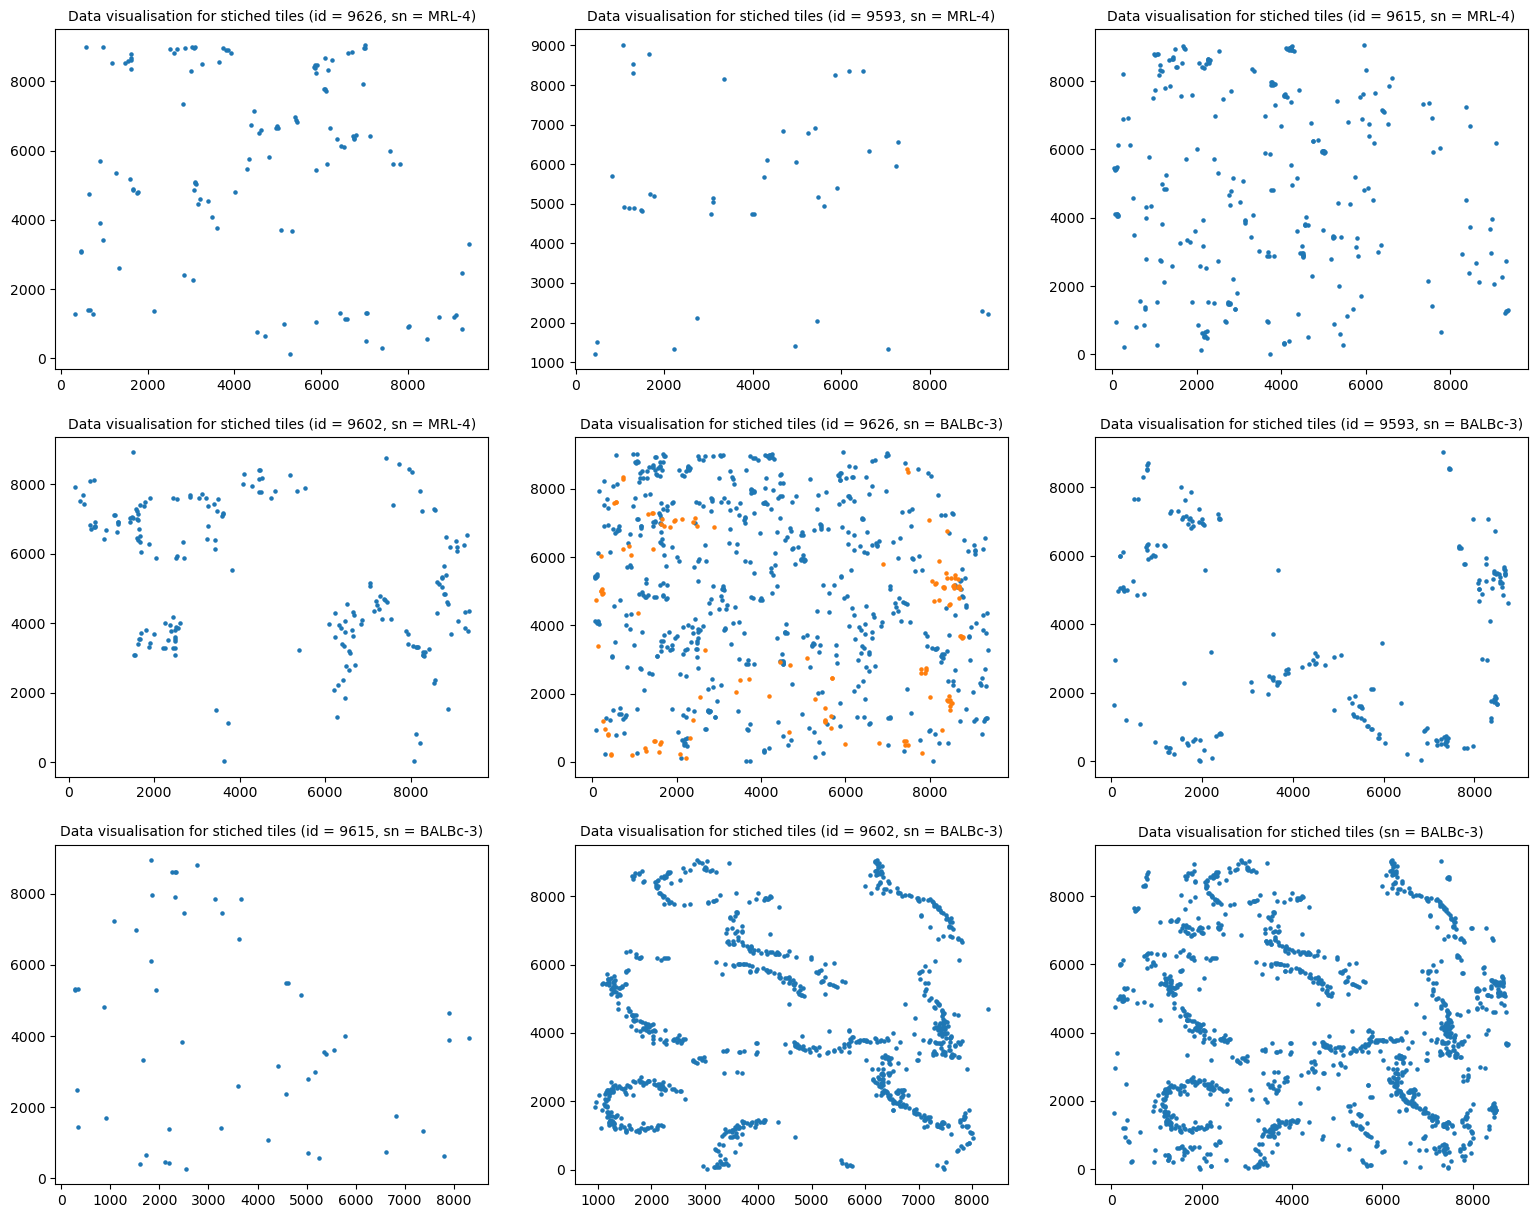

In [15]:
plotting = True
# To plot nicely
plt.figure(figsize=(19, 15))

side = int(np.ceil(np.sqrt(len(IDs) * len(SNs))))

# To Compute Persistence Diagram
rips = Rips(maxdim=1, coeff=2)

# To stich data 
xtilespan = 1344
ytilespan = 1008

# For each sample and each cell type we stich the tiles together

# To store persistence diagram
diagrams = {}

index = 1
for SN in SNs: # each sample
    x_tot = np.empty(0)
    y_tot = np.empty(0)
    for ID in IDs: # each cell type
        # extract relevant rows
        cells = df_cells[(df_cells["Imaging phenotype cluster ID"] == ID) & (df_cells["sample_Xtile_Ytile"].str.split(pat="_").str[0] == SN)]
        if not cells.empty:
            # get (x,y) coordinates
            # tile stiching
            x = np.empty(0)
            y = np.empty(0)
            for i in range(1, 8):
                for j in range(1, 10):
                    xy_cells = cells[(cells["sample_Xtile_Ytile"].str.split(pat="_").str[1] == "X0"+str(i)) & (cells["sample_Xtile_Ytile"].str.split(pat="_").str[2] == "Y0"+str(j))]
                    x = np.append(x, xy_cells["X.X"].values + xtilespan * (i - 1))
                    y = np.append(y, xy_cells["Y.Y"].values + ytilespan * (j - 1))
            if plotting:
                plt.subplot(side, side, index)
                plt.scatter(x, y, s=5)
                plt.title("Data visualisation for stiched tiles (id = " + str(ID)  + ", sn = " + SN + ")", fontsize = 10)
                index += 1
            x_tot = np.append(x_tot, x)
            y_tot = np.append(y_tot, y)
        
            # Computation of Persistence Diagram (For each sample and each cell type)
            data = np.array((x,y)).T
            diagram = rips.fit_transform(data)
            diagrams[(SN, ID)] = diagram

    if plotting:
        plt.subplot(side, side, index)
        plt.scatter(x_tot, y_tot, s=5)
        plt.title("Data visualisation for stiched tiles (sn = " + SN + ")", fontsize = 10)    
    # Computation of Persistence Diagram (For each sample and all cell type)   (Not enough computation power on local computer)    
    # data = np.array((x_tot,y_tot)).T
    # diagram = rips.fit_transform(data)
    # diagrams[SN] = diagram

plt.show()

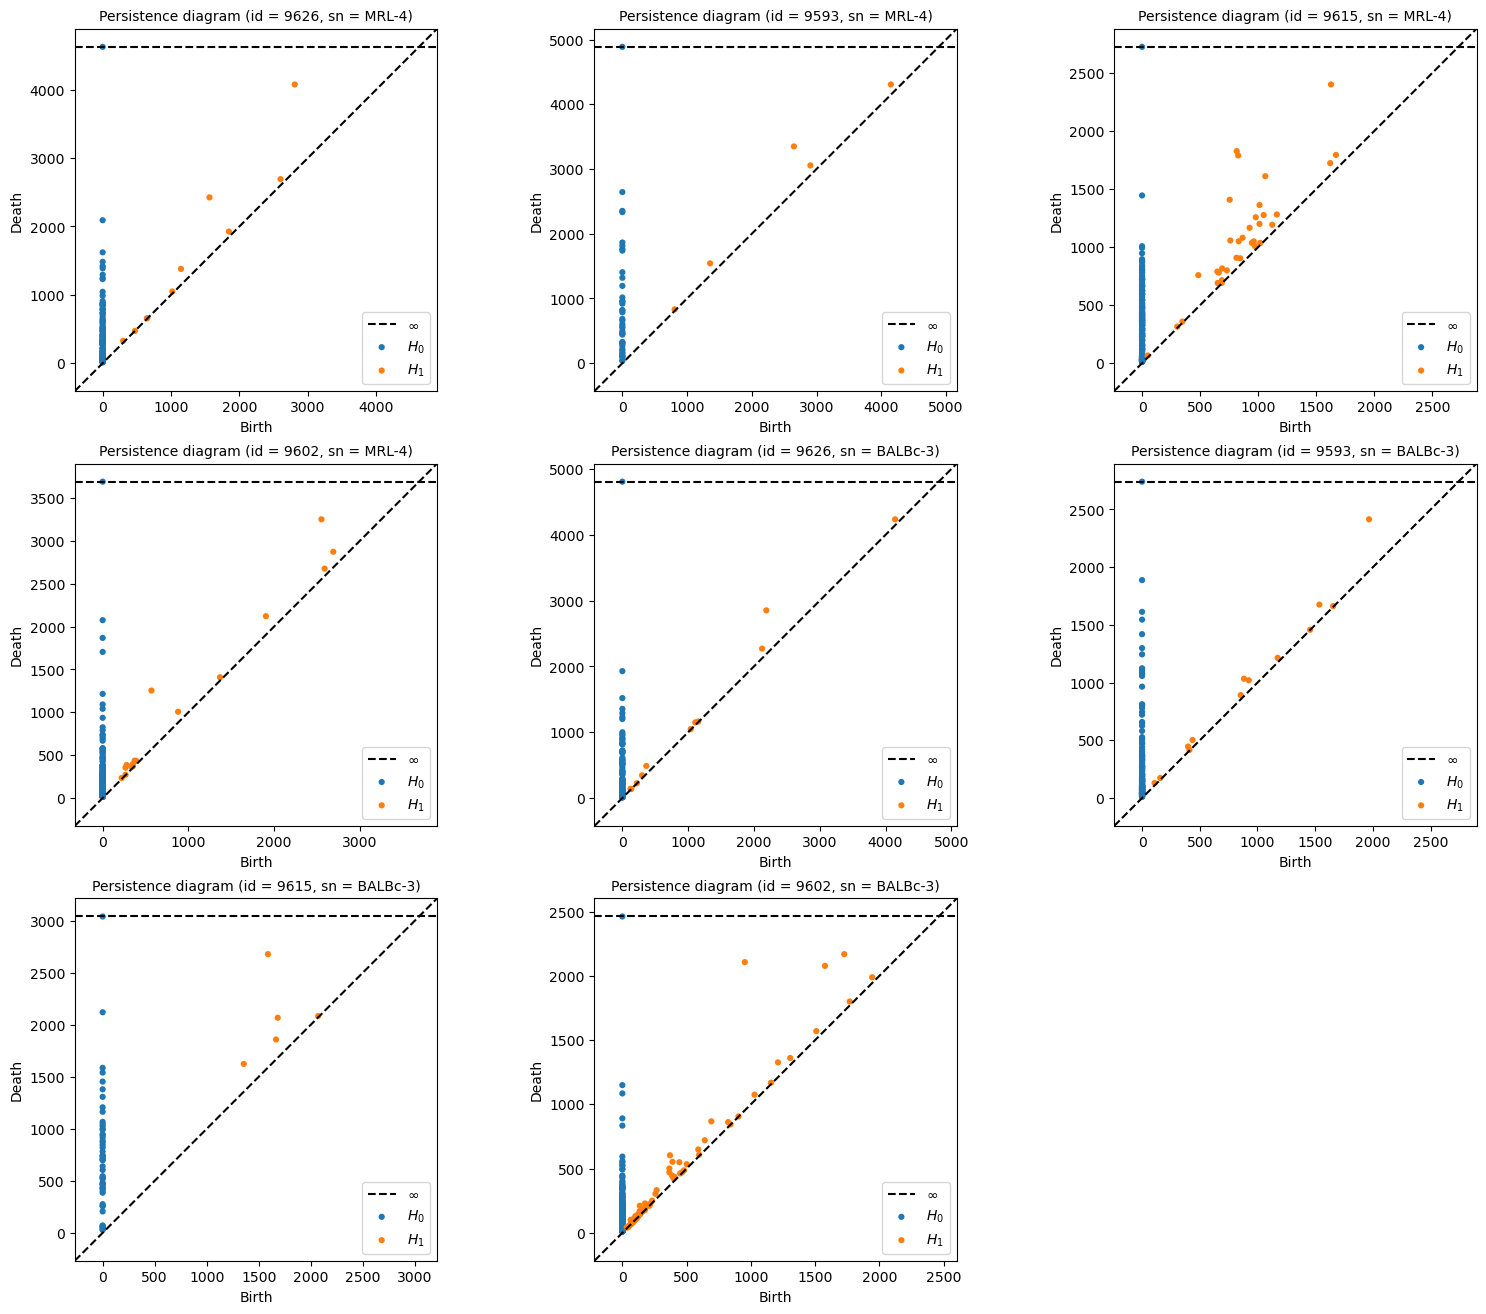

In [7]:
# Ploting diagrams

# To plot nicely
plt.figure(figsize=(19, 16))

side = int(np.ceil(np.sqrt(len(diagrams))))
index = 1

for SN in SNs: # each sample
    for ID in IDs: 
        diagram = diagrams[(SN, ID)]
        plt.subplot(side, side, index)
        rips.plot(diagram, show=False)
        plt.title("Persistence diagram (id = " + str(ID)  + ", sn = " + SN + ")", fontsize = 10)
        index += 1
    
plt.legend(fontsize=10)
plt.show()


## Comparaison of data visualisation and persistence diagram
We can see that in many cases in don't have many structure in our data so the persistence diagram doesn't seems to reveal much but we can notice for example this sample in each we can see a structure which is detected in the persistence diagram since we have a few point of high persistence

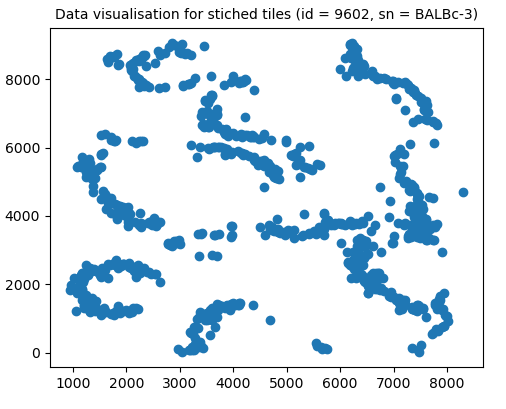 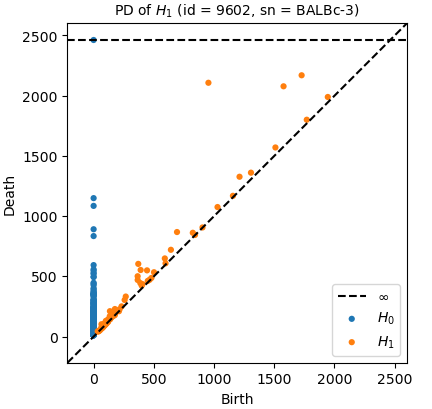



# Computing persistence images

In [11]:
pimgr = PersistenceImager(pixel_size=40)
# pimgr.kernel_params = {'sigma': np.array([[1, 0],[0, 6]])}

In [12]:
# Computing persistence images

images = {}

for SN in SNs: # each sample
    for ID in IDs: 
        diagram = diagrams[(SN, ID)]
        diagram_h1 = diagram[1]
        if np.any(diagram_h1):
            pimgr.fit(diagram_h1)
            image = pimgr.transform(diagram_h1, skew=True)
            images[(SN, ID)] = image

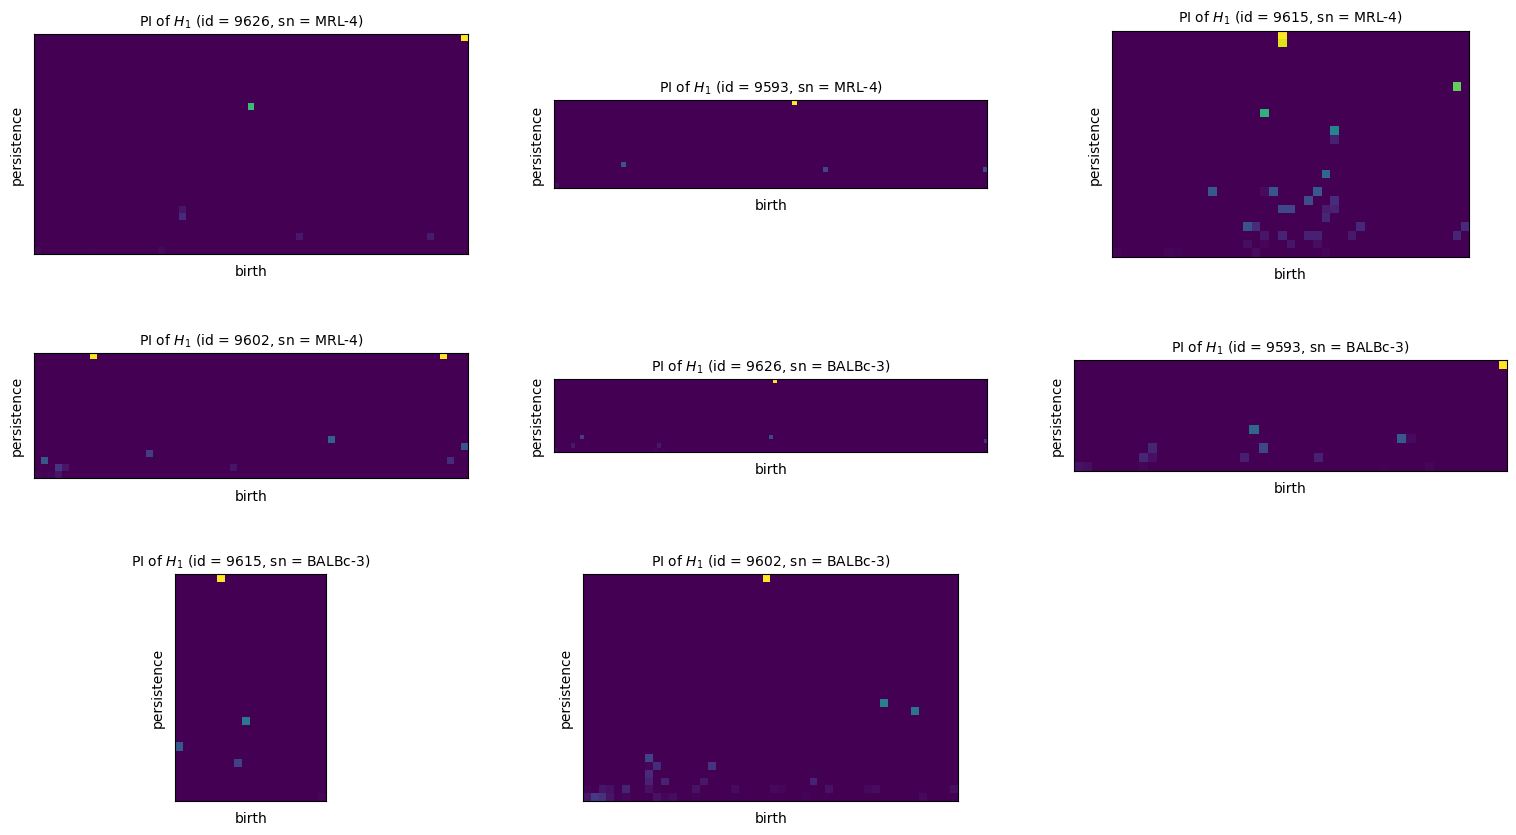

In [13]:
# Plotting persistence images

# To plot nicely
plt.figure(figsize=(19, 10))

side = int(np.ceil(np.sqrt(len(diagrams))))
index = 1

for SN in SNs: # each sample
    for ID in IDs: 
        image = images[(SN, ID)] 
        plt.subplot(side, side, index)
        pimgr.plot_image(image)
        plt.title("PI of $H_1$ (id = " + str(ID)  + ", sn = " + SN + ")", fontsize = 10)
        index += 1
    
plt.show()
